#### Imports & Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.float_format', '{:.2f}'.format)
sns.set(style="whitegrid")

#### Load Cleaned Data

In [2]:
input_file = 'farmer_survey_cleaned_2026.csv'

df = pd.read_csv(input_file, parse_dates=['survey_date'])

print(f"Loaded cleaned dataset: {df.shape[0]} rows, {df.shape[1]} columns")

Loaded cleaned dataset: 1421 rows, 25 columns


In [4]:
print(df.isnull().sum())

farmer_id                      0
country                        0
region                         0
district                       0
village                        0
survey_date                    0
gps_latitude                   0
gps_longitude                  0
crop                           0
farm_size_ha                   0
yield_last_season_kg_ha        0
insured                        0
premium_paid_usd               0
claim_triggered                0
payout_amount_usd              0
field_agent_id                 0
enumerator_notes            1014
flag_missing                   0
flag_duplicate                 0
flag_invalid_gps               0
flag_yield_outlier             0
flag_farm_size_outlier         0
flag_illogical_insurance       0
flag_illogical_claim           0
total_issues                   0
dtype: int64


In [5]:
df.head(5)

,farmer_id,country,region,district,village,survey_date,gps_latitude,gps_longitude,crop,farm_size_ha,...,field_agent_id,enumerator_notes,flag_missing,flag_duplicate,flag_invalid_gps,flag_yield_outlier,flag_farm_size_outlier,flag_illogical_insurance,flag_illogical_claim,total_issues
0,F-Zam-77258,Zambia,Central,Cen-Dist35,Vil-508,2024-07-27,-16.32,27.48,Sorghum,3.78,...,ENUM034,NaN,0,0,0,0,0,0,0,0
1,F-Eth-32245,Ethiopia,Oromia,Oro-Dist12,Vil-917,2024-06-02,11.33,36.28,Wheat,4.84,...,ENUM001,NaN,0,0,0,0,0,0,0,0
2,F-Eth-36922,Ethiopia,Oromia,Oro-Dist03,Vil-912,2023-02-24,12.49,39.25,Beans,4.66,...,ENUM039,NaN,0,0,0,0,0,0,0,0
3,F-Zam-18665,Zambia,Eastern,Eas-Dist19,Vil-267,2023-08-26,-11.20,25.33,Wheat,0.70,...,ENUM022,NaN,0,0,0,0,0,0,0,0
4,F-Zam-83207,Zambia,Eastern,Eas-Dist13,Vil-186,2023-09-15,-13.90,31.72,Wheat,2.10,...,ENUM002,NaN,0,0,0,0,0,0,0,0


#### Compute Global KPIs

In [6]:
# Unique farmers
total_farmers = df['farmer_id'].nunique()

# Insurance metrics
insured_count = df[df['insured'] == 'Yes']['farmer_id'].nunique()
coverage_rate = (insured_count / total_farmers) * 100 if total_farmers > 0 else 0

# Claims metrics
claim_count = df[df['claim_triggered'] == 'Yes']['farmer_id'].nunique()
claim_rate = (claim_count / insured_count) * 100 if insured_count > 0 else 0

total_payout = df['payout_amount_usd'].sum()
avg_payout_per_claim = df[df['claim_triggered'] == 'Yes']['payout_amount_usd'].mean()
avg_payout_per_insured = df[df['insured'] == 'Yes']['payout_amount_usd'].mean()

kpi_summary = {
    'Metric': [
        'Total Unique Farmers',
        'Insured Farmers',
        'Insurance Coverage Rate (%)',
        'Claim-Triggered Farmers',
        'Claim Rate among Insured (%)',
        'Total Payout (USD)',
        'Avg Payout per Claim (USD)',
        'Avg Payout per Insured Farmer (USD)'
    ],
    'Value': [
        total_farmers,
        insured_count,
        round(coverage_rate, 1),
        claim_count,
        round(claim_rate, 1),
        round(total_payout, 2),
        round(avg_payout_per_claim, 2) if not pd.isna(avg_payout_per_claim) else 0,
        round(avg_payout_per_insured, 2) if not pd.isna(avg_payout_per_insured) else 0
    ]
}

kpi_df = pd.DataFrame(kpi_summary)
print("Global KPIs:")
display(kpi_df)

Global KPIs:


,Metric,Value
0,Total Unique Farmers,1421.00
1,Insured Farmers,554.00
2,Insurance Coverage Rate (%),39.00
3,Claim-Triggered Farmers,93.00
4,Claim Rate among Insured (%),16.80
5,Total Payout (USD),30979.56
6,Avg Payout per Claim (USD),289.64
7,Avg Payout per Insured Farmer (USD),51.33


#### Regional Breakdown

##### Regional KPIs

In [8]:
regional_kpis = df.groupby('region').agg(
    total_farmers=('farmer_id', 'nunique'),
    insured=('insured', lambda x: (x == 'Yes').sum()),
    coverage_rate=('insured', lambda x: (x == 'Yes').mean() * 100),
    claims=('claim_triggered', lambda x: (x == 'Yes').sum()),
    total_payout=('payout_amount_usd', 'sum'),
    avg_payout_claim=('payout_amount_usd', lambda x: x[x > 0].mean() if (x > 0).any() else 0)
).round(2)

regional_kpis['claim_rate'] = (regional_kpis['claims'] / regional_kpis['insured']) * 100
regional_kpis = regional_kpis.reset_index()

print("Regional KPIs:")
display(regional_kpis)

Regional KPIs:


,region,total_farmers,insured,coverage_rate,claims,total_payout,avg_payout_claim,claim_rate
0,Amhara,337,127,37.69,16,6057.64,252.40,12.60
1,Central,239,101,42.26,22,6960.15,302.62,21.78
2,Eastern,90,36,40.00,5,1357.46,271.49,13.89
3,Oromia,371,129,34.77,21,6195.37,281.61,16.28
4,Rift Valley,154,65,42.21,14,5048.75,280.49,21.54
5,Southern,89,36,40.45,6,2085.04,260.63,16.67
6,Western,141,60,42.55,9,3275.15,297.74,15.00


##### Visualization: Coverage & Claim Rate by Region

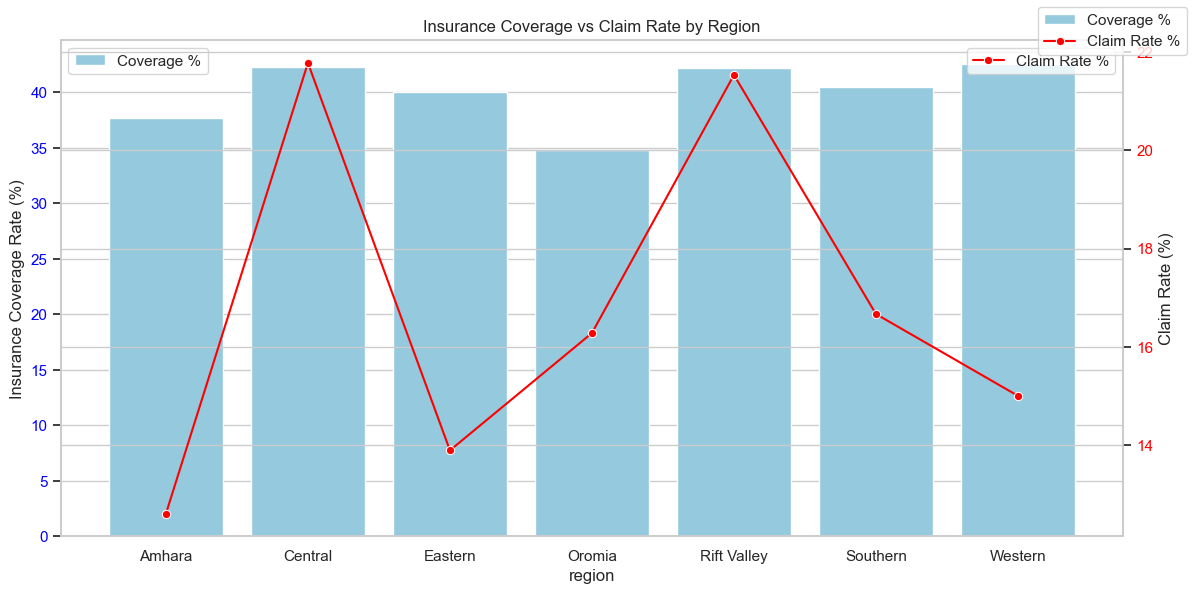

In [9]:
fig, ax1 = plt.subplots(figsize=(12, 6))

sns.barplot(x='region', y='coverage_rate', data=regional_kpis, ax=ax1, color='skyblue', label='Coverage %')
ax1.set_ylabel('Insurance Coverage Rate (%)')
ax1.tick_params(axis='y', labelcolor='blue')

ax2 = ax1.twinx()
sns.lineplot(x='region', y='claim_rate', data=regional_kpis, ax=ax2, color='red', marker='o', label='Claim Rate %')
ax2.set_ylabel('Claim Rate (%)')
ax2.tick_params(axis='y', labelcolor='red')

plt.title('Insurance Coverage vs Claim Rate by Region')
fig.legend(loc='upper right')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

C:\Users\Eldu\AppData\Local\Temp\ipykernel_3800\3575315391.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='region', y='total_payout', data=regional_kpis, palette='viridis')


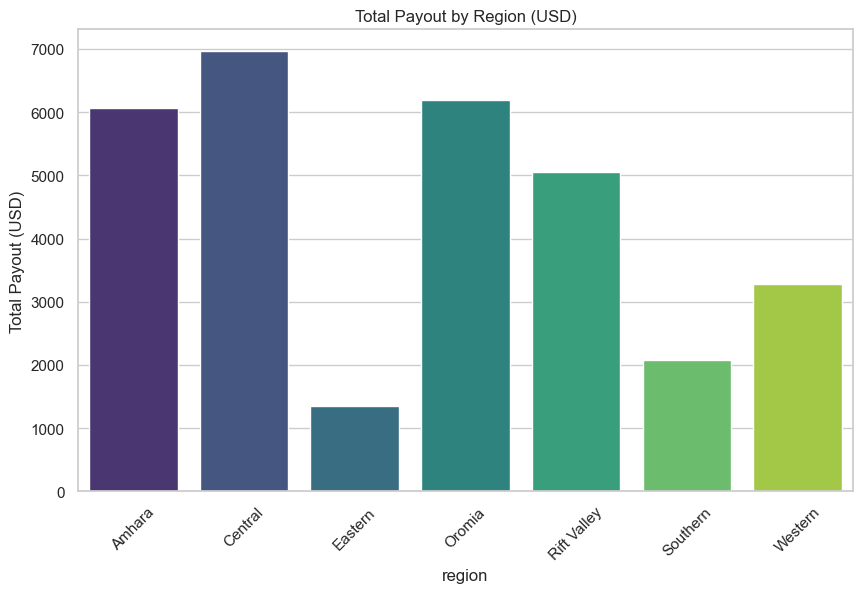

In [6]:
# Payout heat map style (simple bar)
plt.figure(figsize=(10, 6))
sns.barplot(x='region', y='total_payout', data=regional_kpis, palette='viridis')
plt.title('Total Payout by Region (USD)')
plt.ylabel('Total Payout (USD)')
plt.xticks(rotation=45)
plt.show()

#### Agent Performance Metrics

##### Agent-level KPIs (focus on top performers / potential issues)

In [10]:
agent_kpis = df.groupby('field_agent_id').agg(
    farmers_surveyed=('farmer_id', 'nunique'),
    insured=('insured', lambda x: (x == 'Yes').sum()),
    insured_pct=('insured', lambda x: (x == 'Yes').mean() * 100),
    claims=('claim_triggered', lambda x: (x == 'Yes').sum()),
    claim_pct=('claim_triggered', lambda x: (x == 'Yes').mean() * 100),
    total_payout=('payout_amount_usd', 'sum')
).round(2)

# Sort by farmers surveyed descending
agent_kpis = agent_kpis.sort_values('farmers_surveyed', ascending=False)

print("Agent Performance (Top 10 by farmers surveyed):")
display(agent_kpis.head(5))

Agent Performance (Top 10 by farmers surveyed):


,farmers_surveyed,insured,insured_pct,claims,claim_pct,total_payout
field_agent_id,,,,,,
ENUM043,44,17,38.64,3,6.82,1257.18
ENUM041,43,15,34.88,2,4.65,449.31
ENUM035,40,14,35.00,4,10.00,1113.05
ENUM040,37,16,43.24,3,8.11,765.17
ENUM050,36,14,38.89,2,5.56,984.58


In [11]:
print("\nAgents with highest claim % (potential risk clusters):")
display(agent_kpis.sort_values('claim_pct', ascending=False).head(5))


Agents with highest claim % (potential risk clusters):


,farmers_surveyed,insured,insured_pct,claims,claim_pct,total_payout
field_agent_id,,,,,,
ENUM037,23,11,47.83,4,17.39,1003.57
ENUM023,18,9,50.00,3,16.67,886.17
ENUM047,34,16,47.06,5,14.71,1389.95
ENUM016,22,10,45.45,3,13.64,1113.27
ENUM019,30,13,43.33,4,13.33,1614.22


#### Export for Dashboard

In [12]:
kpi_df.to_csv('global_kpis.csv', index=False)
regional_kpis.to_csv('regional_kpis.csv', index=False)
agent_kpis.to_csv('agent_kpis.csv', index=False)